ridge regularization: https://en.wikipedia.org/wiki/Tikhonov_regularization
generalized fourier transform: https://en.wikipedia.org/wiki/Generalized_Fourier_series

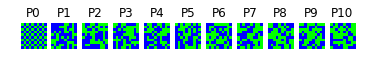

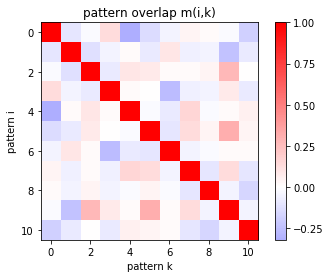

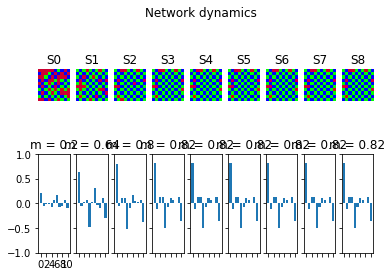

In [31]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from neurodynex.hopfield_network import network, pattern_tools, plot_tools

# increase memory size increases likelihood of converging to proper memory (theoretically)
    # memory is more definitely separated from other memories (more differences) = larger basin of attractions
# increase noise decreases likelihood of converging to proper memory
    # diverges farther from correct memory
# increase number of patterns decreases likelihood of converging to proper memory
    # more possible patterns that perturbed image may look like; smaller basins of attractions

# number of neurons per memory = pattern_size^2
pattern_size = 10

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=10, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)

# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
# which pattern we want to match; then add noise
pattern_number = 0

# nr_of_flips = how much noise to add to input; flip this many tiles from true checkerboard pattern
noisy_init_state = pattern_tools.flip_n(pattern_list[pattern_number], nr_of_flips=40)#checkerboard
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=8) #nr_steps = number of iterations we allow network to converge

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=pattern_number, suptitle="Network dynamics")


the alphabet is stored in an object of type: <class 'dict'>
letters are patterns of size: (10, 10). Create a network of corresponding size


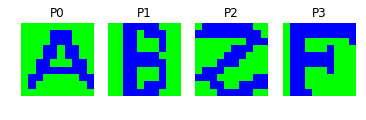

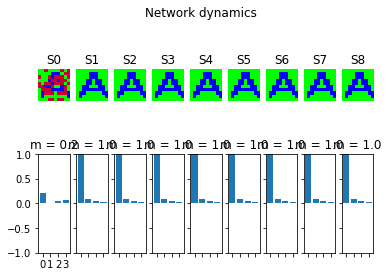

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from neurodynex.hopfield_network import network, pattern_tools, plot_tools
import numpy

# the letters we want to store in the hopfield network
letter_list = ['A', 'B', 'Z', 'F']

# set a seed to reproduce the same noise in the next run
# numpy.random.seed(123)

abc_dictionary =pattern_tools.load_alphabet()
print("the alphabet is stored in an object of type: {}".format(type(abc_dictionary)))
# access the first element and get it's size (they are all of same size)
pattern_shape = abc_dictionary['A'].shape
print("letters are patterns of size: {}. Create a network of corresponding size".format(pattern_shape))
# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_shape[0]*pattern_shape[1])

# create a list using Pythons List Comprehension syntax:
pattern_list = [abc_dictionary[key] for key in letter_list ]
plot_tools.plot_pattern_list(pattern_list)

# store the patterns
hopfield_net.store_patterns(pattern_list)

pattern_list[0].shape
# # create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(abc_dictionary['A'], nr_of_flips=40)#checkerboard

hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=8)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = pattern_tools.reshape_patterns(states, pattern_list[0].shape)

# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(
    states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


Computing spectral radius...
done.
MSE = 0.006819552335252658


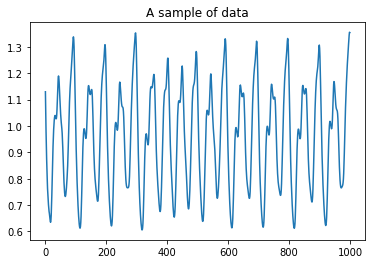

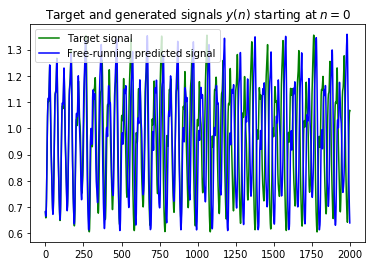

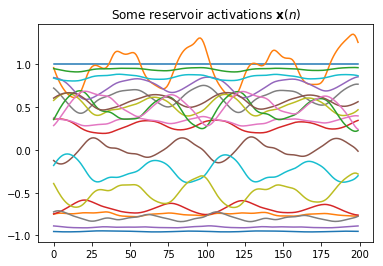

In [18]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas LukoÅ¡eviÄ?ius 2012
http://minds.jacobs-university.de/mantas
"""
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg

# load the data
trainLen = 2000
testLen = 2000
initLen = 100

data = np.load('mackey_glass_t17.npy')

data = exp(sin(data))

# plot some of it
figure(10).clear()
plot(data[0:1000])
title('A sample of data')

# generate the ESN reservoir
inSize = outSize = 1
resSize = 1000





a = 0.3 # leaking rate -> IMPORTANT: higher = longer memory




random.seed(42)
Win = (random.rand(resSize,1+inSize)-0.5) * 1
W = random.rand(resSize,resSize)-0.5 
# Option 1 - direct scaling (quick&dirty, reservoir-specific):
#W *= 0.135 
# Option 2 - normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...'),
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')





# RADIUS: IMPORTANT -> higher = more chaos
W *= 1.25 / rhoW

# allocated memory for the design (collected states) matrix
X = zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1]

# run the reservoir with the data and collect X
x = zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    
    
    # activation function = tanh (convert input activation -> neurons activation; i.e. same purpose as sigmoid)
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = vstack((1,u,x))[:,0]
    
# train the output
reg = 1e-8  # regularization coefficient
X_T = X.T
Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + \
    reg*eye(1+inSize+resSize) ) )
#Wout = dot( Yt, linalg.pinv(X) )

# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    y = dot( Wout, vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( square( data[trainLen+1:trainLen+errorLen+1] - Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))
    
# plot some signals
figure(1).clear()
plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plot( Y.T, 'b' )
title('Target and generated signals $y(n)$ starting at $n=0$')
legend(['Target signal', 'Free-running predicted signal'])

figure(2).clear()
plot( X[0:20,0:200].T )
title('Some reservoir activations $\mathbf{x}(n)$')


show()





